# Edge AI Anomaly Detection

## Overview

This document contains the code for our EclipseCON 2022 Talk: "_How to Train Your Dragon and Its Friends: AI on the Edge with Eclipse Kura&trade;_"

In this notebook we'll cover:
- **Data collection**: how to retrieve training data from the field leveraging Eclipse Kura&trade; and Eclipse Kapua&trade;
- **Data processing**: how to explore our training data and manipulate them to make them suitable for training (feature selection, scaling and dataset splitting). This will provide us with the "_Preprocessing_" stage of the AI pipeline
- **Model training**: how we can create a simple Autoencoder in Keras and how to train it. This will provide us with the "_Inference_" stage of the AI pipeline
- **Model evaluation**: how can we extract the high level data from the model output and ensure the model was trained correctly. This will provide us with the "_Postprocessing_" stage of the AI pipeline
- **Model deployment**: how we can convert the model to make it suitable for running on Eclipse Kura&trade; and Nvidia Triton&trade; and deploy it on the edge.

---

## Data collection

[WIP]

---

## Data Processing

We can now work on our `.csv` file downloaded from Kapua. For demonstration purposes a copy is provided within this repository.

In [ ]:
!ls *.csv

Let's start taking a look at the content of this dataset, we'll use [pandas](https://pandas.pydata.org/) (Python Data Analysis library) for this.

As you might notice we're already taking away some features from the dataset (through the `usecols` parameter of the `read_csv` function). This is because there's some information in the dataset we don't care about (`ID` and the timestamps, for example, are not meaningful for our application).

In [1]:
import pandas as pd

raw_data = pd.read_csv("./train-data-raw.csv")

raw_data.head()

,ID,TIMESTAMP,MAGNET_X,TEMP_HUM_timestamp,MAGNET_Z,MAGNET_Y,ACC_Y,ACC_X,GYRO_Y_timestamp,ACC_Z,...,PRESSURE_timestamp,MAGNET_X_timestamp,ACC_X_timestamp,GYRO_Z_timestamp,HUMIDITY_timestamp,assetName,ACC_Z_timestamp,GYRO_X,GYRO_Y,GYRO_Z
0,1,1645778791786,-2.680372,1645778791413,5.036951,8.646852,0.004364,0.080122,1645778791413,0.984048,...,1645778791413,1645778791413,1645778791413,1645778791413,1645778791413,asset-sensehat,1645778791413,0.053243,0.028920,0.036950
1,2,1645778792381,-3.110756,1645778792378,5.952562,10.521458,0.005091,0.080122,1645778792378,0.992090,...,1645778792378,1645778792378,1645778792378,1645778792378,1645778792378,asset-sensehat,1645778792378,-0.051105,-0.028920,-0.037256
2,3,1645778793412,-3.482263,1645778793408,6.719675,11.944528,0.005334,0.080122,1645778793408,0.986729,...,1645778793408,1645778793408,1645778793408,1645778793408,1645778793408,asset-sensehat,1645778793408,-0.025253,0.025560,0.038478
3,4,1645778794411,-3.813552,1645778794407,7.375115,13.093461,0.006061,0.080122,1645778794407,0.990384,...,1645778794407,1645778794407,1645778794407,1645778794407,1645778794407,asset-sensehat,1645778794407,0.100695,-0.023422,-0.037867
4,5,1645778795411,-4.050513,1645778795407,7.854155,14.029530,0.004849,0.080607,1645778795407,0.988922,...,1645778795407,1645778795407,1645778795407,1645778795407,1645778795407,asset-sensehat,1645778795407,-0.100389,0.021895,0.038172


### Feature selection

As you might notice there's some information in the dataset we don't care about and are not meaningful for our application:
- `ID`
- The various `timestamps`
- `assetName` which doesn't change

Then we can remove them from the dataset.

In [2]:
features = ['ACC_Y', 'ACC_X', 'ACC_Z',
            'PRESSURE', 'TEMP_PRESS', 'TEMP_HUM',
            'HUMIDITY', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']

data = raw_data[features]

data.head()

,ACC_Y,ACC_X,ACC_Z,PRESSURE,TEMP_PRESS,TEMP_HUM,HUMIDITY,GYRO_X,GYRO_Y,GYRO_Z
0,0.004364,0.080122,0.984048,992.322998,38.724998,40.330822,19.487146,0.053243,0.028920,0.036950
1,0.005091,0.080122,0.992090,992.288330,38.772915,40.385788,19.465750,-0.051105,-0.028920,-0.037256
2,0.005334,0.080122,0.986729,992.275635,38.795834,40.349144,19.572731,-0.025253,0.025560,0.038478
3,0.006061,0.080122,0.990384,992.279053,38.797916,40.330822,19.358767,0.100695,-0.023422,-0.037867
4,0.004849,0.080607,0.988922,992.333008,38.845833,40.385788,19.390862,-0.100389,0.021895,0.038172


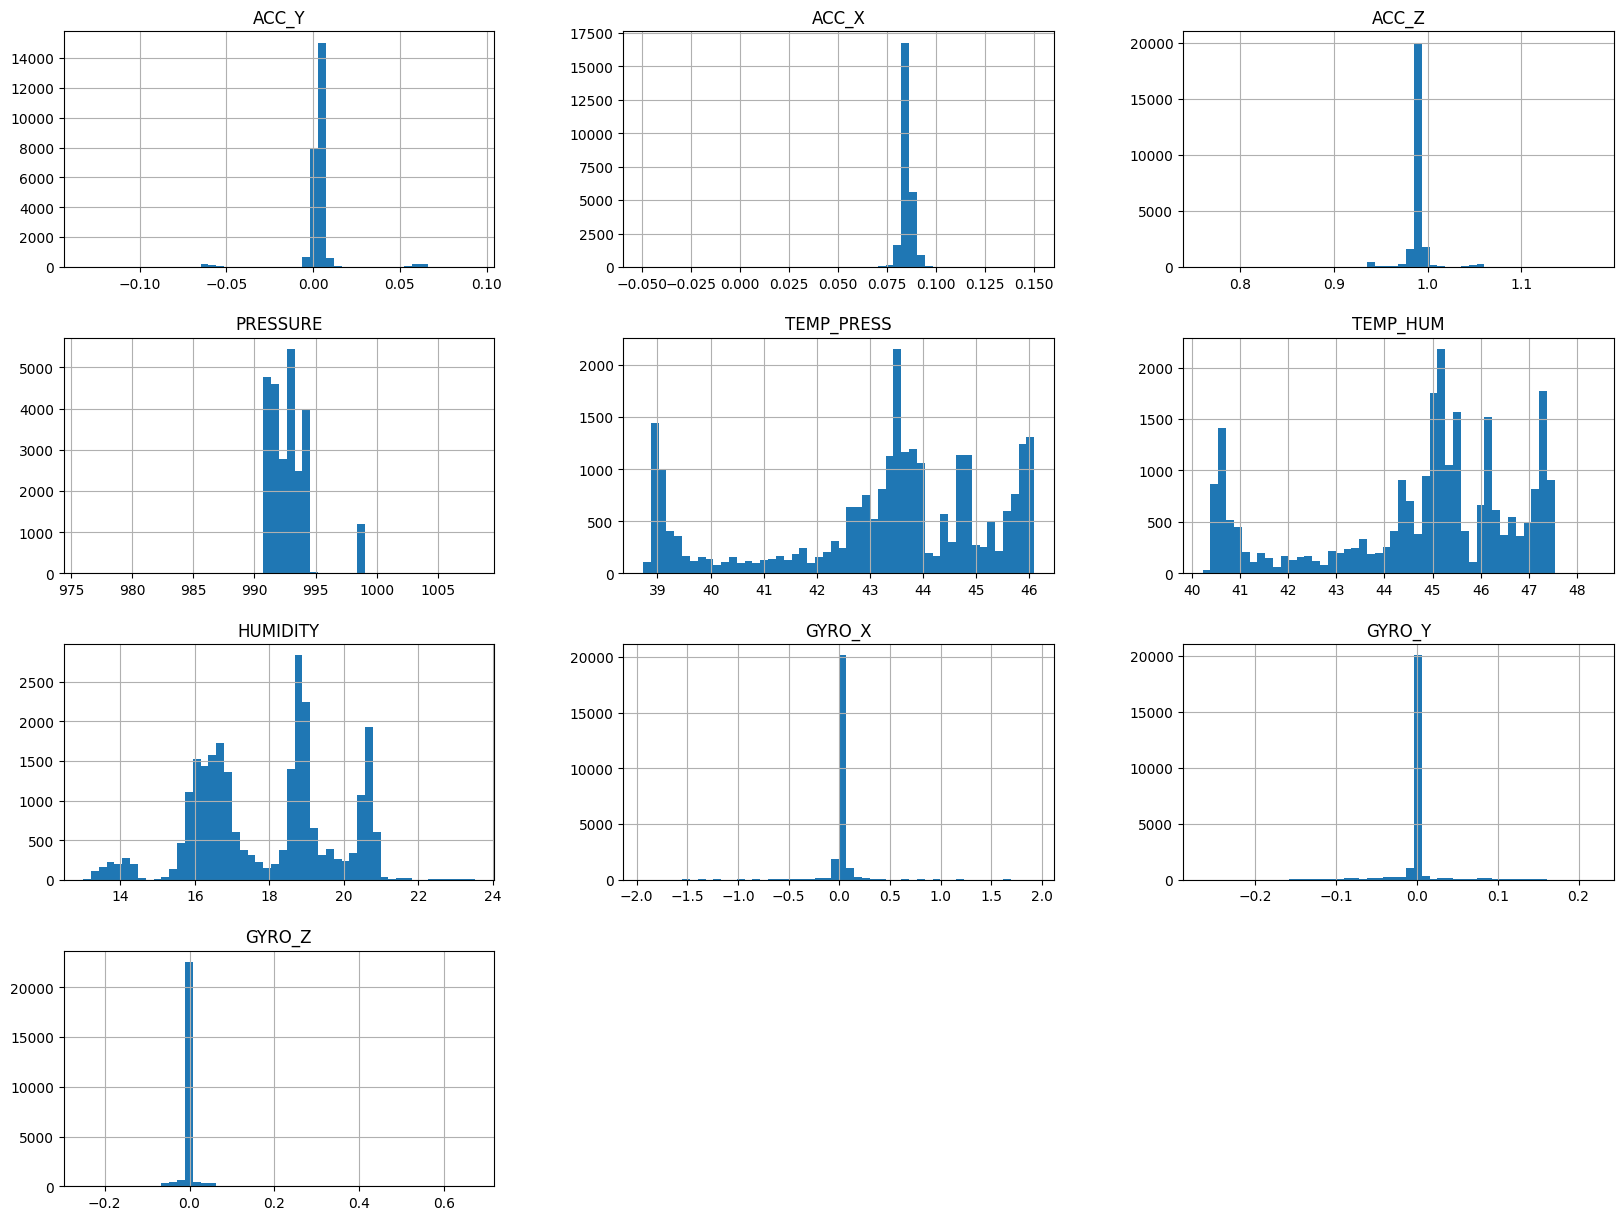

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

data.hist(bins=50, figsize=(20,15))
plt.show()

### Feature scaling

AI models don't perform well when the input numerical attributes have very different scales. As you can see `ACC_X`, `ACC_Y` and `ACC_Z` range from 0 to 1, while the `PRESSURE` have far higher values.

There are two common ways to address this: _normalization_ and _standardization_.

_Normalization_ (a.k.a. Min-max scaling) shifts and rescales values so that they end up ranging from 0 to 1. This can be done by subtracting the min value and dividing by the max minus the min.

x' = $\frac{x - min(x)}{max(x) - min(x)}$

_Standardization_ makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation.

x' = $\frac{x - avg(x)}{\sigma}$

Fortunately for us [scikit-learn](https://scikit-learn.org/stable/) library provides a function for both of them. In this case we'll use _normalization_ because it works well for this application.

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.to_numpy())

In [5]:
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000
mean,0.603124,0.674196,0.550454,0.526446,0.605576,0.552252,0.466400,0.501160,0.545457,0.271295
std,0.049333,0.015135,0.031627,0.054050,0.288300,0.256587,0.176293,0.062908,0.067678,0.014665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.597087,0.667343,0.544924,0.481917,0.501060,0.441442,0.325637,0.501348,0.544670,0.270709
50%,0.603534,0.673413,0.551342,0.521377,0.655357,0.608108,0.511715,0.501841,0.547096,0.271685
75%,0.611055,0.680698,0.555426,0.552892,0.819339,0.734234,0.575212,0.502407,0.549386,0.272577
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Train test split

The only way to know how well a model will generalize to new data points is to try it on new data. To do so we split our data into two sets: the training set and the test set.

To do so we'll use a function from `scikit-learn`.

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test = train_test_split(scaled_data, test_size=0.3, random_state=42)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

---

## Model training

We can now leverage the [Keras](https://keras.io/) API of [Tensorflow](https://www.tensorflow.org/) for creating our Autoencoder and then train it on our dataset.

In this example we'll use a basic fully-connected autoencoder.

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Avoid AVX2 error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_model(input_dim):
    # Latent space dimension
    latent_dim = 4

    # The encoder will consist of a number of dense layers that decrease in size
    # as we taper down towards the bottleneck of the network, the latent space
    input_data = Input(shape=(input_dim,), name='INPUT0')

    # hidden layers
    encoder = Dense(24, activation='tanh', name='encoder_1')(input_data)
    encoder = Dropout(.15)(encoder)
    encoder = Dense(16, activation='tanh', name='encoder_2')(encoder)
    encoder = Dropout(.15)(encoder)

    # bottleneck layer
    latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

    # The decoder network is a mirror image of the encoder network
    decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
    decoder = Dropout(.15)(decoder)
    decoder = Dense(24, activation='tanh', name='decoder_2')(decoder)
    decoder = Dropout(.15)(decoder)

    # The output is the same dimension as the input data we are reconstructing
    reconstructed_data = Dense(input_dim, activation='linear', name='OUTPUT0')(decoder)

    autoencoder_model = Model(input_data, reconstructed_data)

    return autoencoder_model

In [8]:
autoencoder_model = create_model(len(features))

In [9]:
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT0 (InputLayer)         [(None, 10)]              0         
                                                                 
 encoder_1 (Dense)           (None, 24)                264       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 encoder_2 (Dense)           (None, 16)                400       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 latent_encoding (Dense)     (None, 4)                 68        
                                                                 
 decoder_1 (Dense)           (None, 16)                80    

### Model training

As we already explained in the presentation, the autoencoder is a  type of artificial neural network used to learn efficient codings of unlabeled data. We'll use that to reconstruct the input at the output. Being trained on the "normal" data of the system, it won't be able to reconstruct correctly "anomalous" data and thus will work as an anomaly detector.

Our loss function, which we need to minimize during our training, is the error between the _input data_ and the _data reconstructed by the autoencoder_. We'll use the mean squared error.

In [10]:
from tensorflow.keras import optimizers

batch_size = 64
max_epochs = 10
learning_rate = .0001

opt = optimizers.Adam(learning_rate=learning_rate)
autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
autoencoder_model.fit(x_train, x_train,
                      shuffle=True,
                      epochs=max_epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test))

Epoch 1/10
277/277 [==============================] - 1s 3ms/step - loss: 0.3186 - accuracy: 0.0777 - val_loss: 0.0999 - val_accuracy: 0.1578
Epoch 2/10
277/277 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.1122 - val_loss: 0.0254 - val_accuracy: 0.3117
Epoch 3/10
277/277 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.1648 - val_loss: 0.0174 - val_accuracy: 0.3089
Epoch 4/10
277/277 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.1945 - val_loss: 0.0149 - val_accuracy: 0.3099
Epoch 5/10
277/277 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.2248 - val_loss: 0.0123 - val_accuracy: 0.5108
Epoch 6/10
277/277 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.2498 - val_loss: 0.0093 - val_accuracy: 0.6457
Epoch 7/10
277/277 [==============================] - 0s 2ms/step - loss: 0.0331 - accuracy: 0.2847 - val_loss: 0.0066 - val_accuracy: 0.6692
Epoch 

We can save the model on disk as we'll use this later.

In [11]:
autoencoder_model.save("./saved_model/autoencoder")

INFO:tensorflow:Assets written to: ./saved_model/autoencoder/assets


INFO:tensorflow:Assets written to: ./saved_model/autoencoder/assets


In [12]:
!ls ./saved_model/autoencoder

assets            keras_metadata.pb saved_model.pb    variables


---

## Model evaluation

We now have a model that reconstruct the input at the output... doesn't sounds really useful right?

Let's see it in action. Let's take a sample from the test set and run it through our autoencoder.

In [13]:
input_sample = x_test[3:4].copy()

reconstructed_sample = autoencoder_model.predict(input_sample)

print(input_sample)
print(reconstructed_sample)

1/1 [==============================] - 0s 111ms/step
[[0.603534   0.6770555  0.54900813 0.5327966  0.6680801  0.6171171
  0.5198642  0.50135666 0.54716927 0.2718224 ]]
[[0.59628457 0.672222   0.54944056 0.51685745 0.6323804  0.5684962
  0.45321336 0.5037341  0.54495    0.2738853 ]]


Text(0.5, 1.0, 'Input data')

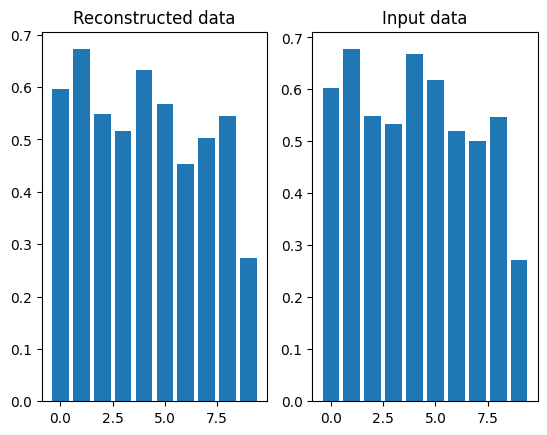

In [14]:
import matplotlib.pyplot as plt

x_axis = range(0, 10)

figure, axis = plt.subplots(1, 2)

axis[0].bar(x_axis, reconstructed_sample[0])
axis[0].set_title("Reconstructed data")

axis[1].bar(x_axis, input_sample[0])
axis[1].set_title("Input data")

What happens if we manipulate this sample in a way the autoencoder doesn't expect?

Let's try and set the `ACC_Z` to a value the autoencoder has never seen before.

In [18]:
input_anomaly = input_sample.copy()

input_anomaly[0][2] = 0.3

reconstructed_anomaly = autoencoder_model.predict(input_anomaly)

print(input_anomaly)
print(reconstructed_anomaly)

1/1 [==============================] - 0s 24ms/step
[[0.603534   0.6770555  0.3        0.5327966  0.6680801  0.6171171
  0.5198642  0.50135666 0.54716927 0.2718224 ]]
[[0.58800817 0.64615357 0.52430195 0.4933016  0.5962665  0.53596616
  0.43386045 0.4869592  0.5238275  0.2688104 ]]


Text(0.5, 1.0, 'Input anomaly')

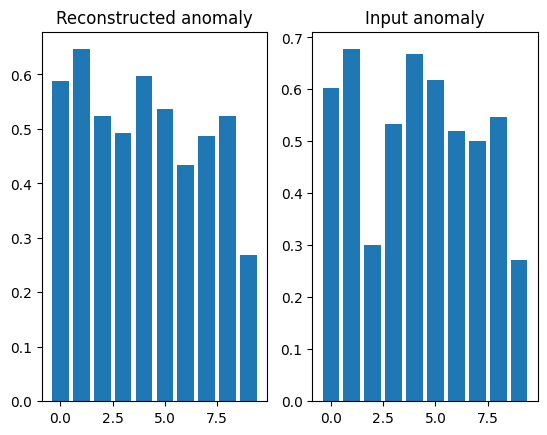

In [19]:
figure, axis = plt.subplots(1, 2)

axis[0].bar(x_axis, reconstructed_anomaly[0])
axis[0].set_title("Reconstructed anomaly")

axis[1].bar(x_axis, input_anomaly[0])
axis[1].set_title("Input anomaly")

The autoencoder fails to reconstruct the data it received at the input. This means that the reconstruction error is very high.

In [23]:
from sklearn.metrics import mean_squared_error

print("Anomaly %f.6"% mean_squared_error(input_anomaly[0], reconstructed_anomaly[0]))
print("Normal  %f.6"% mean_squared_error(input_sample[0], reconstructed_sample[0]))

Anomaly 0.007297.6
Normal  0.000843.6


It's working as expected!

We now need to decide when to trigger an alarm (i.e. classify an input sample as anomalous) from this data. A common strategy is to comput the max value of the reconstruction error in the test set and set a threshold based on this value.

In [28]:
x_test_recon = autoencoder_model.predict(x_test)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)  # MSE

anomaly_data = pd.DataFrame({'recon_score': reconstruction_scores})
print(anomaly_data.describe())

237/237 [==============================] - 0s 747us/step
       recon_score
count  7584.000000
mean      0.003958
std       0.005663
min       0.000108
25%       0.001030
50%       0.002090
75%       0.003714
max       0.105607


In [29]:
alpha = 1.5
threshold = np.max(reconstruction_scores) * alpha
print("Anomaly score threshold: %f" % threshold)

Anomaly score threshold: 0.158410


We now have our anomaly detector, we need to deploy it on our Kura device.

---

## Model deployment

[WIP]